# Pipe3: 
## To classify location of damage - front, rear or behind.

In [1]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter 
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1

In [3]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [4]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_acc'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [5]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)

In [43]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0]*(41) + [1]*(28) + [2]*(27))
    train_labels = to_categorical(train_labels)
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0]*(40) + [1]*(29) + [2]*(27))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
        
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model,fit.history

In [44]:
def finetune_categorical_model():
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [45]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Image dataset details

In [46]:
location = 'data3'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'
model1 = location+'/bottleneck_fc_model.h5'
train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 96
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 96

img_width, img_height = 256,256
epochs = 96
batch_size = 16

In [47]:
save_bottleneck_features()

Found 96 images belonging to 3 classes.
Found 96 images belonging to 3 classes.


In [48]:
d3_model, d3_history = train_categorical_model()

Epoch 1/96
6/6 [==============================] - 2s 159ms/step - loss: 20.2824 - accuracy: 0.3021 - val_loss: 5.0981 - val_accuracy: 0.3438
Epoch 2/96
6/6 [==============================] - 1s 131ms/step - loss: 6.5775 - accuracy: 0.4896 - val_loss: 3.6580 - val_accuracy: 0.4479
Epoch 3/96
6/6 [==============================] - 1s 125ms/step - loss: 4.5026 - accuracy: 0.5208 - val_loss: 0.7227 - val_accuracy: 0.7708
Epoch 4/96
6/6 [==============================] - 1s 113ms/step - loss: 1.6412 - accuracy: 0.7188 - val_loss: 0.2130 - val_accuracy: 0.9375
Epoch 5/96
6/6 [==============================] - 1s 135ms/step - loss: 3.2260 - accuracy: 0.4688 - val_loss: 0.3607 - val_accuracy: 0.8646
Epoch 6/96
6/6 [==============================] - 1s 136ms/step - loss: 0.6068 - accuracy: 0.7917 - val_loss: 0.2538 - val_accuracy: 0.8958
Epoch 7/96
6/6 [==============================] - 1s 154ms/step - loss: 0.2170 - accuracy: 0.9271 - val_loss: 0.2679 - val_accuracy: 0.9375
Epoch 8/96
6/6 [===

Epoch 39/96
6/6 [==============================] - 1s 120ms/step - loss: 0.0908 - accuracy: 0.9688 - val_loss: 0.2108 - val_accuracy: 0.9688
Epoch 40/96
6/6 [==============================] - 1s 120ms/step - loss: 0.0836 - accuracy: 0.9896 - val_loss: 0.2633 - val_accuracy: 0.9688
Epoch 41/96
6/6 [==============================] - 1s 125ms/step - loss: 0.1977 - accuracy: 0.9583 - val_loss: 0.2871 - val_accuracy: 0.9688
Epoch 42/96
6/6 [==============================] - 1s 150ms/step - loss: 0.1688 - accuracy: 0.9583 - val_loss: 0.2922 - val_accuracy: 0.9688
Epoch 43/96
6/6 [==============================] - 1s 132ms/step - loss: 0.1506 - accuracy: 0.9688 - val_loss: 0.2084 - val_accuracy: 0.9688
Epoch 44/96
6/6 [==============================] - 1s 124ms/step - loss: 0.1706 - accuracy: 0.9688 - val_loss: 0.1934 - val_accuracy: 0.9688
Epoch 45/96
6/6 [==============================] - 1s 135ms/step - loss: 0.1015 - accuracy: 0.9583 - val_loss: 0.2454 - val_accuracy: 0.9688
Epoch 46/96
6

6/6 [==============================] - 1s 127ms/step - loss: 0.4249 - accuracy: 0.9479 - val_loss: 0.3837 - val_accuracy: 0.9688
Epoch 77/96
6/6 [==============================] - 1s 147ms/step - loss: 0.1539 - accuracy: 0.9688 - val_loss: 0.2956 - val_accuracy: 0.9688
Epoch 78/96
6/6 [==============================] - 1s 154ms/step - loss: 0.1267 - accuracy: 0.9792 - val_loss: 0.3411 - val_accuracy: 0.9688
Epoch 79/96
6/6 [==============================] - 1s 158ms/step - loss: 0.1224 - accuracy: 0.9688 - val_loss: 0.3196 - val_accuracy: 0.9688
Epoch 80/96
6/6 [==============================] - 1s 149ms/step - loss: 0.1972 - accuracy: 0.9792 - val_loss: 0.3894 - val_accuracy: 0.9688
Epoch 81/96
6/6 [==============================] - 1s 155ms/step - loss: 0.1207 - accuracy: 0.9896 - val_loss: 0.3702 - val_accuracy: 0.9688
Epoch 82/96
6/6 [==============================] - 1s 125ms/step - loss: 0.2472 - accuracy: 0.9688 - val_loss: 0.3845 - val_accuracy: 0.9688
Epoch 83/96
6/6 [========

In [50]:
d3_history

{'loss': [20.28244400024414,
  6.577472686767578,
  4.502578258514404,
  1.641190528869629,
  3.2260265350341797,
  0.6068100333213806,
  0.21703289449214935,
  0.24743179976940155,
  0.15109463036060333,
  0.2977902591228485,
  0.18146289885044098,
  1.750428318977356,
  2.8436105251312256,
  0.2022726982831955,
  0.38401320576667786,
  0.1999085694551468,
  0.06573078036308289,
  0.4406642019748688,
  0.2807217836380005,
  1.2090765237808228,
  0.10649284720420837,
  0.3877802789211273,
  0.29003170132637024,
  0.19209998846054077,
  0.17716671526432037,
  0.09340161830186844,
  0.21943087875843048,
  0.3192409574985504,
  1.4252713918685913,
  0.39038896560668945,
  0.15267153084278107,
  0.269532173871994,
  0.3236791789531708,
  0.7098329663276672,
  0.3363400399684906,
  0.3613990247249603,
  0.054707515984773636,
  0.1270810067653656,
  0.09081923961639404,
  0.08363145589828491,
  0.19769640266895294,
  0.16883207857608795,
  0.1506403237581253,
  0.17056895792484283,
  0.10153

In [52]:
d3_model.save('pipe3model.h5')

In [30]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 976 images belonging to 3 classes.
Found 176 images belonging to 3 classes.
Epoch 1/50
61/61 [==============================] - 828s 14s/step - loss: 1.1973 - acc: 0.8145 - val_loss: 1.9150 - val_acc: 0.7614

Epoch 00001: val_acc improved from -inf to 0.76136, saving model to data3/ft_model.h5
Epoch 2/50
 6/61 [=>............................] - ETA: 9:30 - loss: 1.3216 - acc: 0.7812

KeyboardInterrupt: 

In [18]:
ft_model = load_model('data3/bottleneck_fc_model.h5')

ValueError: Cannot create group in read only mode.

In [52]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [53]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 176 images belonging to 3 classes.


KeyboardInterrupt: 

## Pipe3.1

In [54]:
def pipe31(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

In [55]:
Image('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg')

In [56]:
pipe31('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg', model1)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000024E42D9F9E8>

In [ ]:
Image('https://drndata.com/wp-content/uploads/2016/03/car.jpg')

In [57]:
pipe31('https://drndata.com/wp-content/uploads/2016/03/car.jpg', ft_model)

NameError: name 'ft_model' is not defined

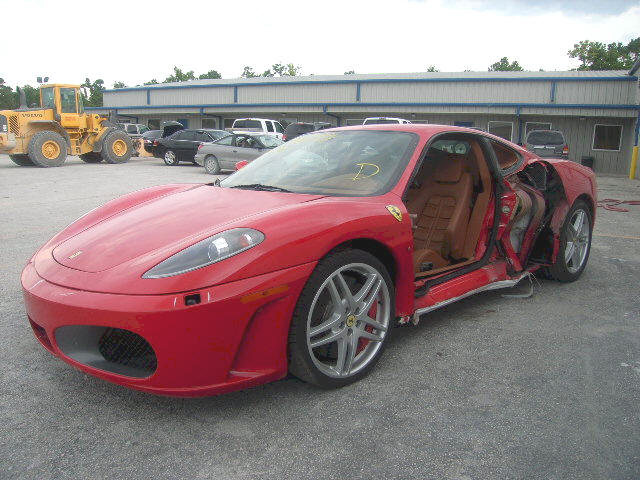

In [58]:
Image('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')

In [59]:
pipe31('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)

NameError: name 'ft_model' is not defined